Apache Spark の mllib には情報推薦でよく使われる Matrix Factorization （以下 MF）を計算するための ALS アルゴリズムが実装されています。 MF は直感的に理解しやすいモデルですし、 Spark を使えば大規模な user-item 行列にも適用できるのですが、実際に ALS がどういうアルゴリズムなのか知って使うのか、それともブラックボックスとして使うのかでは大きな違いがある、というのが個人的な考えです。

というわけでこの記事では [Large-scale Parallel Collaborative Filtering for the Netflix Prize](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf) を参考に ALS が内部で何をしているのかを確認してから、実際に実装してみたいと思います。

## MF の数理

MF ではレーティング行列２つの行列 $P$ と $Q$ で近似します。

$$
R \approx P \times Q^\mathrm{T} = \hat{R}
$$

ユーザの総数を $|U|$、 商品の総数を $|D|$ とすると $P$ と $Q$ はそれぞれ $|U| \times K$ 行列と $|D| \times K$ 行列となります。このとき $K$ はモデルに与えられるパラメータで潜在因子の数を表します。

このときユーザ $u$ の商品 $i$ に対するレーティングの推定値 $\hat{r}_{ui}$ は

$$
\hat{r}_{ui} = \mathbf{p}_u^\mathrm{T} \mathbf{q}_i
$$

で与えられます。 $P$ と $Q$ を計算するには、 $I$ を $R$ の中で実際に値が与えられている $u$ と $i$ の組を表すとして、二乗誤差に L1 正則化を加えた

$$
L = \sum_{(u, i) \in I} (r_{ui} - \hat{r}_{ui})^2 + \alpha \|P\| + \beta \|Q\|
$$

を損失関数として最小化する方法があります。このアルゴリズムは 2006 年の [Netflix Prize](https://www.netflixprize.com/) で Simon Funk によって提案されたので、一般的に **Funk SVD** と呼ばれています。

Funk SVD は単一のコンピュータ上で計算するには適していますが、スケーラビリティに問題がありました。今日ではテラバイトあるいはペタバイトという大きなのデータを扱うこともあるので、そのような規模のデータを一つのマシンで処理するのは大変です。

## Alternating Least Square (ALS)

スケーラビリティを改善するために提案されたのが ALS です。 ALS では L2 正則化を行います。

$$
L = \sum_{(u,i) \in I} (r_{ui} - \mathbf{p}_u^\mathrm{T}\mathbf{q}_i)^2 + \lambda \Biggl(\sum_u n_{p_u}\|\mathbf{p}_u\|^2 + \sum_i n_{q_i}\|\mathbf{q}_i\|^2\Biggr)
$$

ここで $n_{p_u}$ と $n_{q_i}$ はそれぞれユーザ $u$ と商品 $i$ のレーティングの数を表します。また $I_u$ がユーザ $u$ が評価した商品の集合です。この損失関数を $p_{uk}$ で偏微分してみると：

$$
\begin{aligned}
\frac{1}{2} \frac{\partial L}{\partial p_{uk}} &= \sum_{i \in I_u}(\mathbf{p}_u^\mathrm{T}\mathbf{q}_i - r_{ui})q_{ik} + \lambda n_{p_u} p_{ku} \\
  &= \sum_{i \in I_u} q_{ik} \mathbf{q}_i^\mathrm{T}\mathbf{p}_u - \sum_{i \in I_u} q_{ik}r_{ui} + \lambda n_{p_u} p_{ku}
\end{aligned}
$$

$1$ から $K$ までの潜在因子 $k$ を並べてベクトルとしてまとめると：

$$
\begin{aligned}
\frac{1}{2} \frac{\partial L}{\partial \mathbf{p}_u} &= Q_{I_u} Q_{I_u}^\mathrm{T} \mathbf{p}_u - Q_{I_u} R^\mathrm{T} (u, I_n) + \lambda n_{p_u} \mathbf{p}_u \\
  &= (Q_{I_u} Q_{I_u}^\mathrm{T} + \lambda n_p E) \mathbf{p}_u - Q_{I_u} R^\mathrm{T} (u, I_n)
\end{aligned}
$$

ここで $Q_{I_u}$ は $Q$ の中からユーザ $u$ が評価した商品 $I_u$ に関する行だけを抜き出したもので、$ R^\mathrm{T} (u, I_n)$ は $R$ からユーザ $u$ の行の中から商品 $I_u$ に関するものだけを抜き出したベクトルを表します。

$$
\begin{aligned}
\frac{\partial L}{\partial \mathbf{p}_u} &= 0 \\
\Rightarrow \; \mathbf{p}_u &= (Q_{I_u} Q_{I_u}^\mathrm{T} + \lambda n_p E)^{-1} Q_{I_u} R^\mathrm{T} (u, I_n) \\
\Rightarrow \; \mathbf{p}_u &= A_u^{-1}V_u
\end{aligned}
$$

このようにユーザ因子行列 $P$ は $Q$ と $R$ だけに依存して更新できることが分かります。 $q_{ik}$ で偏微分して整理していけば同様に商品因子行列 $Q$ が $P$ と $R$ だけを使って更新できることが示されます。

ALS ではこの式を用いて $P$ と $Q$ を交互に更新し、損失関数が変化しなくなるまで反復します。問題は $A_u$ の逆行列が存在するのか定かでないことですが、この点についてもとの論文にも特に言及がなかったのでよくわかっていません。

### 分散処理
巨大なデータセットに対して ALS を実行する際にもっとも影響が大きな影響をもつのが $R$ です。 $R$ は $|U| \times |D|$ 行列であり、ユーザ数と商品数が増えると猛烈な勢いで大きくなっていきますが、一般に一人のユーザが評価するのは商品のごく一部でしかないので、極めて疎に行列です。データセットが巨大になったとき $R$ をそのままメモリにもつことは困難です。

前述のように ALS では $P$ は $Q$ と $R$ だけを使って更新します。そのため、 $P$ と $Q$ の計算は各反復において互いに独立して並列に行うことができます。

さらに $R$ は更新しているユーザが評価した商品の評価値だけを取り出せばいいので、 [CSC](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_column_(CSC_or_CCS)) のように列方向に圧縮された形式で保持することで、データサイズを小さくしつつ効率的に計算をすることが可能です。

ただこの記事では単純に大変であることに加えて、単一の Jupyter Notebook 上で実装する方法がよく分からないので、分散処理は実装しません。

## ALS を実装する
ALS を実装する際にもっとも紛らわしいのが $Q_{I_u}$ を求める部分でしょう。

仮にレーティング行列として次の $R$ が与えられたとします。

In [1]:
R =  [
    0   4.5 2.0 0;
    4.0 0   3.5 0;
    0   5.0 0   2.0;
    0   3.5 4.0 1.0
]

4×4 Array{Float64,2}:
 0.0  4.5  2.0  0.0
 4.0  0.0  3.5  0.0
 0.0  5.0  0.0  2.0
 0.0  3.5  4.0  1.0

行列の行が上からユーザ 1, 2, 3, 4 に対応し、列が左から商品 1, 2, 3, 4 に対応しているとすると、この行列はユーザ 1 は商品 2 を 4.5、商品 3 を 2.0 と評価し、商品 1 と 4 を評価していないとみなすことができます。なので $K=2$ で

$$
Q = \left(
\begin{array}{ccc}
  q_{11} & q_{12} \\
  q_{21} & q_{22} \\
  q_{31} & q_{32} \\
  q_{41} & q_{42}
\end{array}
\right)
$$

とすると

$$
Q_{I_1} = \left(
\begin{array}{ccc}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0
\end{array}
\right) Q = \left(
\begin{array}{ccc}
  q_{21} & q_{22} \\
  q_{31} & q_{32}
\end{array}
\right)
$$

です。この $Q$ の左からかけているフィルターとなる行列を作る関数を用意します。

In [2]:
"""
ユーザあるいは商品のレーティングベクトルを受け取って、フィルターとなる行列を返す
"""
function filtermatrix(rating::Array)
    result = zeros(Int, (count(rating .!= 0), length(rating)))
    counter = 1
    for (index, value) in enumerate(rating)
        if value != 0
            result[counter, index] = 1
            counter += 1
        end
    end
    result
end

filtermatrix

ユーザ 1 のレーティングを入力として与えると、たしかにさきほど $Q$ にかけたものと同じ行列が返ってきます。$\mathbf{q}_i$ を更新する時に必要になる $P_{I_i}$ も同様に求めることができます：

In [3]:
filtermatrix(R[1:1, :])

2×4 Array{Int64,2}:
 0  1  0  0
 0  0  1  0

本筋からは離れますが、 ALS の中で使うために MSE を計算する関数を用意しておきます：

In [4]:
"""
ベクトル x と ｙ の平均二乗誤差を計算する

x: ベクトル
y: ベクトル
"""
function mse(x::Vector, y::Vector)::Float64
    @assert length(x) == length(y)
    sum((x .- y).^2) / length(x)
end

mse

では ALS を実装します。さきほどの更新式をそのままコードにおとしていくだけです。

In [5]:
using LinearAlgebra

"""
R: レーティング行列
rank: 潜在因子の数
iter: 反復回数
λ: 正規化パラメータ
"""
function als(
        R::Matrix;
        rank::Int=10,
        iter::Int=10,
        λ::Float64=0.001
    )
    usersnum = size(R, 1) # ユーザ数
    itemsnum = size(R, 2)  # 商品数
    
    P = rand(usersnum, rank)  # ユーザ因子行列
    Q = rand(itemsnum, rank)  # 商品因子行列
    
    # 各ユーザと商品の評価数
    np = [count(R[u:u, :] .> 0) for u in 1:usersnum]
    nq = [count(R[:, i:i] .> 0) for i in 1:itemsnum]

    # 各ユーザと商品のフィルター行列
    Iu = [filtermatrix(R[u:u, :]) for u in 1:usersnum]
    Ii = [filtermatrix(R[:, i:i]) for i in 1:itemsnum]
    
    x = R[R .!= 0] # レーティング行列のうち 0 ではないもの
    losses = []  # 各イテレーションごとの mse の値を入れる
    
    for _ in 1:iter
        # ユーザ因子を更新する
        for u in 1:usersnum
            QIu = (Iu[u] * Q)'
            Au = QIu * QIu'  + λ * np[u] * I
            Vu = QIu * Iu[u] * (R[u:u, :])'
            P[u:u, :] = inv(Au) * Vu
        end
        
        # 商品因子を更新する
        for i in 1:itemsnum
            PIi = (Ii[i] * P)'
            Ai = PIi * PIi' + λ * nq[i] * I
            Vi = PIi * Ii[i] * R[:, i:i]
            Q[i:i, :] = inv(Ai) * Vi
        end
        
        # 推定された R
        R̂ = P * Q'
        #  R̂ のうちレーティング行列で 0 ではない要素に対応するもの
        y = R̂[R .!= 0]
        push!(losses, mse(x, y))
    end
    
    P, Q, losses
end

als

## 動作確認
実際に計算してみます：

In [6]:
using Random
Random.seed!(255)
P, Q, losses = als(R)
R̂ = P * Q'

4×4 Array{Float64,2}:
 1.95614  4.49856  2.00126  1.93523 
 3.99916  2.49496  3.5      0.577751
 2.59633  5.00034  2.96279  1.99935 
 2.92678  3.49851  3.99614  1.00025 

$R$ と $\hat{R}$ から $I$ に含まれるものを取り出してみると、かなり近い値が並んでいることが分かります：

In [7]:
println("R = ", R[R .!= 0])
println("R̂ = ", round.(R̂[R .!= 0], digits=3))

R = [4.0, 4.5, 5.0, 3.5, 2.0, 3.5, 4.0, 2.0, 1.0]
R̂ = [3.999, 4.499, 5.0, 3.499, 2.001, 3.5, 3.996, 1.999, 1.0]


誤差の遷移をグラフに表示してみると、反復すると急激に値が小さくなっていくことが分かります。今回使ったレーティング行列はとても小さいので数回の反復で収束しています：

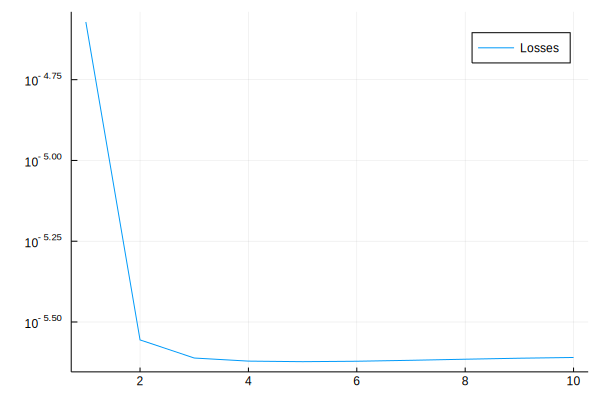

In [8]:
using Plots
Plots.gr()
plot(1:10, losses, label="Losses", yscale=:log10)

ユーザ数と商品数ともに 100 くらいのもっと大きなデータを使ってみます：

In [9]:
R2 = zeros(100, 100)
for u in 1:100, p in 1:100
    if rand() < 0.1
        R2[u, p] = rand() * 5
    end
end

収束が緩やかになっていることが分かります：

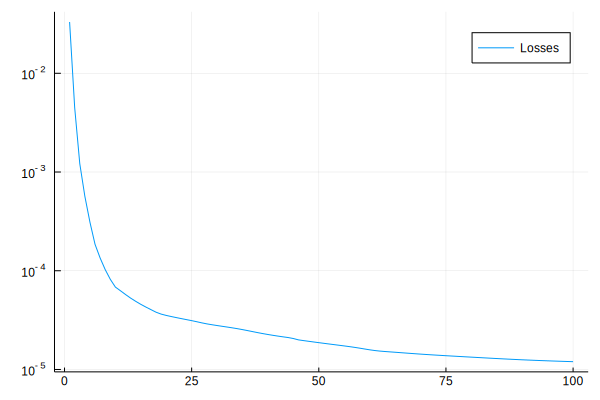

In [10]:
iter = 100
_, _, losses2 = als(R2, iter=iter)
Plots.gr()
plot(1:iter, losses2, label="Losses", yscale=:log10)

## おわりに
協調フィルタリングで広く使われる MF の実装の一つである ALS の数学的な背景とその実装を確認しました。実際に MF する際は Apache Spark に実装された ALS を用いることが多いと思いますが、こうして中身が分かると少しだけ安心感も増す感じがします。

ALS は MF のためのものではありますが、交互に二乗誤差を修正する、という考え方自体は他にも適用できるものです。実際、 Factorization Marchines（FM）の論文では FM が ALS で解けると書かれています。

実はこのブログは当初 FM の勉強のために書こうとしたものなのです。しかしいかんせん、長くなってきたのでここで一旦終わります。機会があれば FM を ALS （または MCMC）で解いてみたいと思います。

## 参考

* [Alternating Least Square (ALS) でCP分解 - でかいチーズをベーグルする](http://yamaguchiyuto.hatenablog.com/entry/2016/11/12/100000)
* [Matrix-Factorization-ALS/ALS Python Implementation.py at master · mickeykedia/Matrix-Factorization-ALS](https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py)
* [Prototyping a Recommender System Step by Step Part 2: Alternating Least Square (ALS) Matrix Factorization in Collaborative Filtering](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1)
* [Alternating Least Squares – Data Science Made Simpler](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)
* [Large-scale Parallel Collaborative Filtering for the Netflix Prize](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf)

なおこの記事は [jupyter/datascience-notebook:7a0c7325e470](https://hub.docker.com/layers/jupyter/datascience-notebook/7a0c7325e470/images/sha256-18ef2702c6a25bd26b81e7b6dc831adb2bc294ae7bc9b011150b8f4573c41d4a) で起動した Jupyter Notebook を使って書かれています：

```bash
docker run --rm -it -p 8888:8888 -v $PWD/pages:/app/notebooks -w /app/notebooks jupyter/datascience-notebook:7a0c7325e470
```